# TP 1 - Reconocimiento de patrones

In [1]:
import os
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
import matplotlib.pyplot as plt

### Importamos los datos

In [2]:
housing = pd.read_csv('./data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


housing.hist(bins=50, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

---
## Set de Training y Testing

In [3]:
# Misma semilla que se utiliza en el libro
np.random.seed(42)

In [4]:
housing['income_category'] = pd.cut(housing['median_income'],
                                    bins=[0., 1.5, 3., 4.5, 6., np.inf],
                                    labels=[1,2,3,4,5])

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_category"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [6]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

In [7]:
# Reasigno housing = train_set (No perdemos datos, ya que train + test = housing original)
housing = strat_train_set.copy()

---
## Visualizacion de los datos geograficos

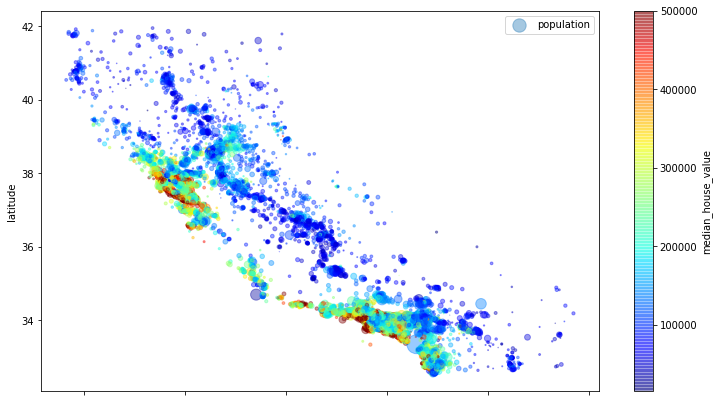

In [8]:
housing.plot(
    kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(12.5,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

#### Esta imagen es mucho mas representativa, ya que podemos ver las zonas altamente pobladas mucho mas facil, y los precios promedios tambien.

---
## Analizando correlaciones
#### Obtenemos la matriz de correlacion de los datos

In [9]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

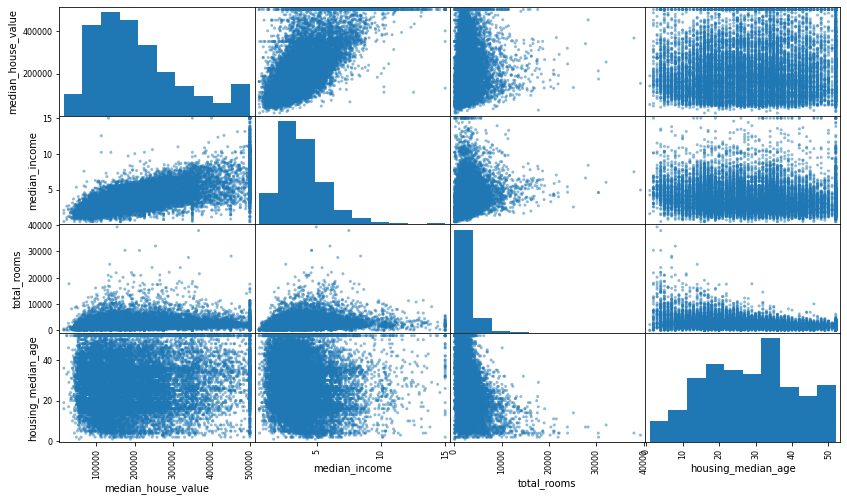

In [10]:
from pandas.plotting import scatter_matrix

scatter_matrix = scatter_matrix(housing[["median_house_value", "median_income", "total_rooms", "housing_median_age"]], figsize=(14, 8))

---
## Enriquecimiento de los datos

In [11]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [12]:
housing.corr()["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

---
## Preparando los datos para los modelos de Machine Learning

In [13]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

In [14]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

#### Manejando atributos categoricos y texto

In [15]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(5)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


## Transformadores personalizados

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling & Transformation Pipelines

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
 ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [19]:
housing_prepared[:1]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

---
## Seleccion de modelos y Entrenamiento

In [45]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

## Ridge
ridge_reg = linear_model.Ridge(alpha=0.1)

ridge_reg.fit(housing_prepared, housing_labels)

ridge_scores = cross_val_score(ridge_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)
display_scores(ridge_rmse_scores)

## Lasso

lasso_reg = linear_model.Lasso(alpha=0.5)
lasso_reg.fit(housing_prepared, housing_labels)

lasso_scores = cross_val_score(lasso_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error")
lasso_rmse_scores = np.sqrt(-lasso_scores)
display_scores(lasso_rmse_scores)

## ElasticNet

elasticnet_reg = linear_model.ElasticNet(alpha=4)
elasticnet_reg.fit(housing_prepared, housing_labels)

elasticnet_scores = cross_val_score(elasticnet_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error")
elasticnet_rmse_scores = np.sqrt(-elasticnet_scores)
display_scores(elasticnet_rmse_scores)

NameError: name 'cross_val_score' is not defined

# GridSearch

### Ridge - RidgeCV
### Lasso - LassoCV
### ElasticNet - ElasticNetCV

In [20]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

from sklearn.model_selection import GridSearchCV

In [21]:
alphas = list(np.linspace(0.1, 1.0, num=10)) + list(np.linspace(2.0, 10.0, num=5))

In [51]:
ridge_param = [
    { "alpha": alphas }
]

ridge_regressor = Ridge()
ridge_grid = GridSearchCV(ridge_regressor, ridge_param, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
ridge_grid.fit(housing_prepared, housing_labels)

print(ridge_grid.best_estimator_)

In [22]:
lasso_param = [
    { "alpha": alphas[5:12], "max_iter": [10000] }
]

lasso_regressor = Lasso()
lasso_grid = GridSearchCV(lasso_regressor, lasso_param, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
lasso_grid.fit(housing_prepared, housing_labels)

print(lasso_grid.best_estimator_)

Lasso(max_iter=10000)


In [23]:
lasso_grid.best_params_

{'alpha': 1.0, 'max_iter': 10000}